# Gaussian Fluctuations

## This notebook creates a map of Gaussian Fluctuations

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import camb

import copy

In [47]:
Nmax = 401

kmax = Nmax/2

In [48]:
# kx array 

L = 10

x_list = []

for i in range(0, Nmax):
    
    kxn = i
    
    kx = 2*np.pi/L * (kxn - kmax)
    
    x_list.append(kx)

x_array = np.asarray(x_list)


In [49]:
# According to the equation, all kyn for a given n are the same (i.e. all ROWS are the same)
# So, all kyn = kxn for the same n

y_array = copy.deepcopy(x_array) # Copy the array (although I could have just kept kx, since they are equal)

In [50]:
# Building the k-array

k_map = np.zeros((Nmax, Nmax))

for i in range(0, len(x_array)):
    
    for j in range(0, len(y_array)):
        
        k = np.sqrt(x_array[i]**2 + y_array[j]**2)
        
        k_map[j][i] += k


In [51]:
# Define l as a function of k

def l(k):
    '''
    return spherical harmonics component 'l' as a function of wavenumber k
    '''
    
    return 360*k/(2*np.pi)

In [52]:
# Now, find l's associated with these k's
# Round it so Cl's are easier to find

l_map = np.zeros((Nmax, Nmax))

for i in range(0, len(x_array)):
    for j in range(0, len(y_array)):
    
        
        l_map[j][i] += round(l(k_map[j][i]))
        

## The cell below contains code taken directly from the CAMB demo notebook available at: https://camb.readthedocs.io/en/latest/CAMBdemo.html

In [53]:
############################## COPY-PASTE CAMB DEMO CODE ##########################################

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

  
# Where lensed_scalar corresponds to the B modes

#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).

# Need to go to very high l values:
ls_float = np.linspace(0, 11000, 11001)

ls = []

for i in ls_float:
    
    ls.append(int(i))
    
ls = np.asarray(ls)

######


pars.set_for_lmax(11000, lens_potential_accuracy=1)
results = camb.get_results(pars)
lmax2500CL = results.get_lensed_scalar_cls(CMB_unit='muK') ## THIS is the array of interest for us


total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [54]:
# But lmax2500CL corresponds to l(l+1)Cl/2pi, so I must isolate Cl

Cl = lmax2500CL[:len(ls), 2] *2*np.pi/(ls*(ls+1)) 

# Every index in the Cl array corresponds to a value of l equal to that index
# At index 1, l=1; at index 2, l=2; etc.


/Users/jadeducharme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jadeducharme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
# Finally, replace values in l array by corresponding Cl values:

Cl_map = np.zeros((Nmax, Nmax))

for i in range(0, len(x_array)):
    
    for j in range(0, len(y_array)):
        
        index = ls[int(l_map[j][i])]
        
        if index == 0: # The zeros give wonky results (nan) so let's avoid that!
            continue
            
        else:
            Cl_map[j][i] += Cl[index]

        

In [56]:
# Construct the Fourier space map using the appropriate equation

fourier_map = np.zeros((Nmax, Nmax), dtype='complex')


for i in range(0, len(x_array)):
    for j in range(0, len(y_array)):
        
        g1 = np.random.normal()
        g2 = np.random.normal()
        
        fourier_map[j][i] += np.sqrt(Cl_map[j][i]/2 + 0j) * (g1 + g2*1j)


In [57]:
position_map = np.fft.fft2(fourier_map)

# However, this is a 401x401 map! We need 400x400

position_map_rowdel = np.delete(position_map, obj=0, axis=0) # Deletes the first row
position_map_coldel = np.delete(position_map_rowdel, obj=0, axis=1) # Deletes the first column

# Finally, we just want the real part:

position_map_real = position_map_coldel.real


position_map_real.shape # As expected, we now have 400x400 


(400, 400)

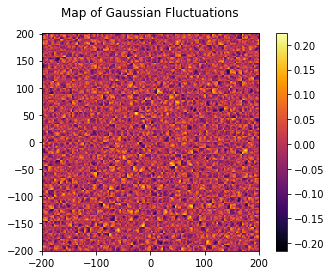

In [58]:
from matplotlib.colors import LogNorm

from matplotlib.colors import SymLogNorm

plt.imshow(position_map_real, cmap='inferno', extent=[-1/2 * Nmax, 1/2 * Nmax, -1/2 * Nmax, 1/2 * Nmax])
# The 'extent' argument centers the map at (0,0) 
# so instead of having it go from 0 to 400, it goes from -200 to 200

plt.title("Map of Gaussian Fluctuations", y=1.05)

plt.colorbar()

# plt.savefig("Example.png", dpi=1000, bbox_inches='tight') 

plt.show()